In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, compute_2dFourier_cbases,compute_H, count_params
from models.Galerkin import GkNN
from models.myGkNN7 import myGkNN7

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config_2D_7.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["FFT_2D"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data1 = loadmat(data_path)
# data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth2"
# data2 = loadmat(data_path)
# data_in = np.vstack((data1["coeff"], data2["coeff"]))  # shape: 2048,421,421
# data_out = np.vstack((data1["sol"], data2["sol"]))     # shape: 2048,421,421
data_in = data1["coeff"]
data_out = data1["sol"]
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)

Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   # shape: 800,11236,3  (11236 = 106*106 , 106-1 = (421-1) /4)
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   # shape: 800,11236,1
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)



###################################
#compute fourier bases
###################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Np, Np, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
pca_data_in = data_in_ds.reshape((data_in_ds.shape[0], -1))
pca_data_out = data_out_ds.reshape((data_out_ds.shape[0], -1))

print("Start SVD with data shape: ", pca_data_out.shape)

bases_pca_in, wbases_pca_in = compute_2dpca_bases(Np , k_max , L,  pca_data_in)
bases_pca_in, wbases_pca_in = bases_pca_in.to(device), wbases_pca_in.to(device)

bases_pca_out, wbases_pca_out = compute_2dpca_bases(Np , k_max , L,  pca_data_out)
bases_pca_out, wbases_pca_out = bases_pca_out.to(device), wbases_pca_out.to(device)



from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])

data_in.shape: (1024, 421, 421)
data_out.shape (1024, 421, 421)
x_train.shape:  torch.Size([800, 961, 3])
y_train.shape:  torch.Size([800, 961, 1])
Start SVD with data shape:  (800, 961)


torch.Size([64, 96])
torch.Size([64, 96, 96])


C:\Users\15461\AppData\Local\Temp\ipykernel_16580\3456020203.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


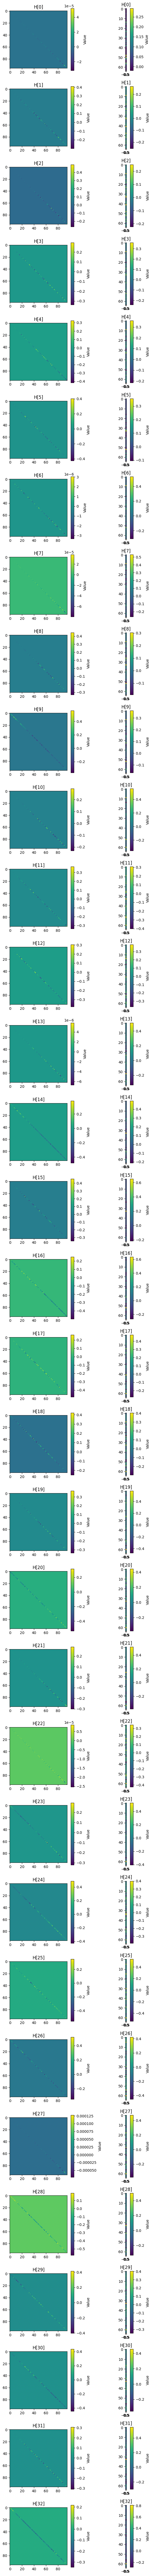

In [10]:
model = torch.load('model/diag_96_64')
D = model.D_out.to('cpu')
print(D.shape)   #64,96,96
H = torch.diag_embed(D).to(D.device)
print(H.shape)

import matplotlib.pyplot as plt
n = 33
m = 2
fig = plt.figure(figsize=(3*m,3*n))
with torch.no_grad():
    for index in range(n):
        H_i = H[index,:,:]
        ax = fig.add_subplot(n, m, m*index+1)
        im = ax.imshow(H_i)
        ax.set_title('H[{}]'.format(index))
        # # 添加颜色条
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Value')

    for index in range(n):
        H_k = H[:,index,index].unsqueeze(1)
        ax = fig.add_subplot(n, m, m*index+2)
        im = ax.imshow(H_k)
        ax.set_title('H[{}]'.format(index))
        # # 添加颜色条
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Value')


    fig.suptitle('', y=0.98)
    plt.tight_layout()
    fig.show()

torch.Size([64, 96, 96])


C:\Users\15461\AppData\Local\Temp\ipykernel_24108\1419358939.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


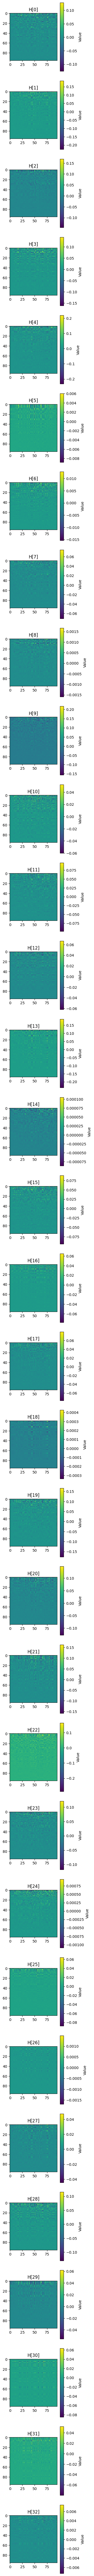

In [2]:
model = torch.load('model/rank1_96_64')
U = model.U_out.to('cpu')
A = model.A_out.to('cpu')
B = model.B_out.to('cpu')
H = torch.einsum('ji,ik,il -> jkl',U, A,B)
print(H.shape)

import matplotlib.pyplot as plt
n = 33
m = 2
fig = plt.figure(figsize=(3*m,3*n))
with torch.no_grad():
    for index in range(n):
        H_i = H[index,:,:]
        ax = fig.add_subplot(n, m, m*index+1)
        im = ax.imshow(H_i)
        ax.set_title('H[{}]'.format(index))
        # # 添加颜色条
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Value')



    fig.suptitle('', y=0.98)
    plt.tight_layout()
    fig.show()